In [1]:
import torch
from torch import nn
from d2l import torch as d2l

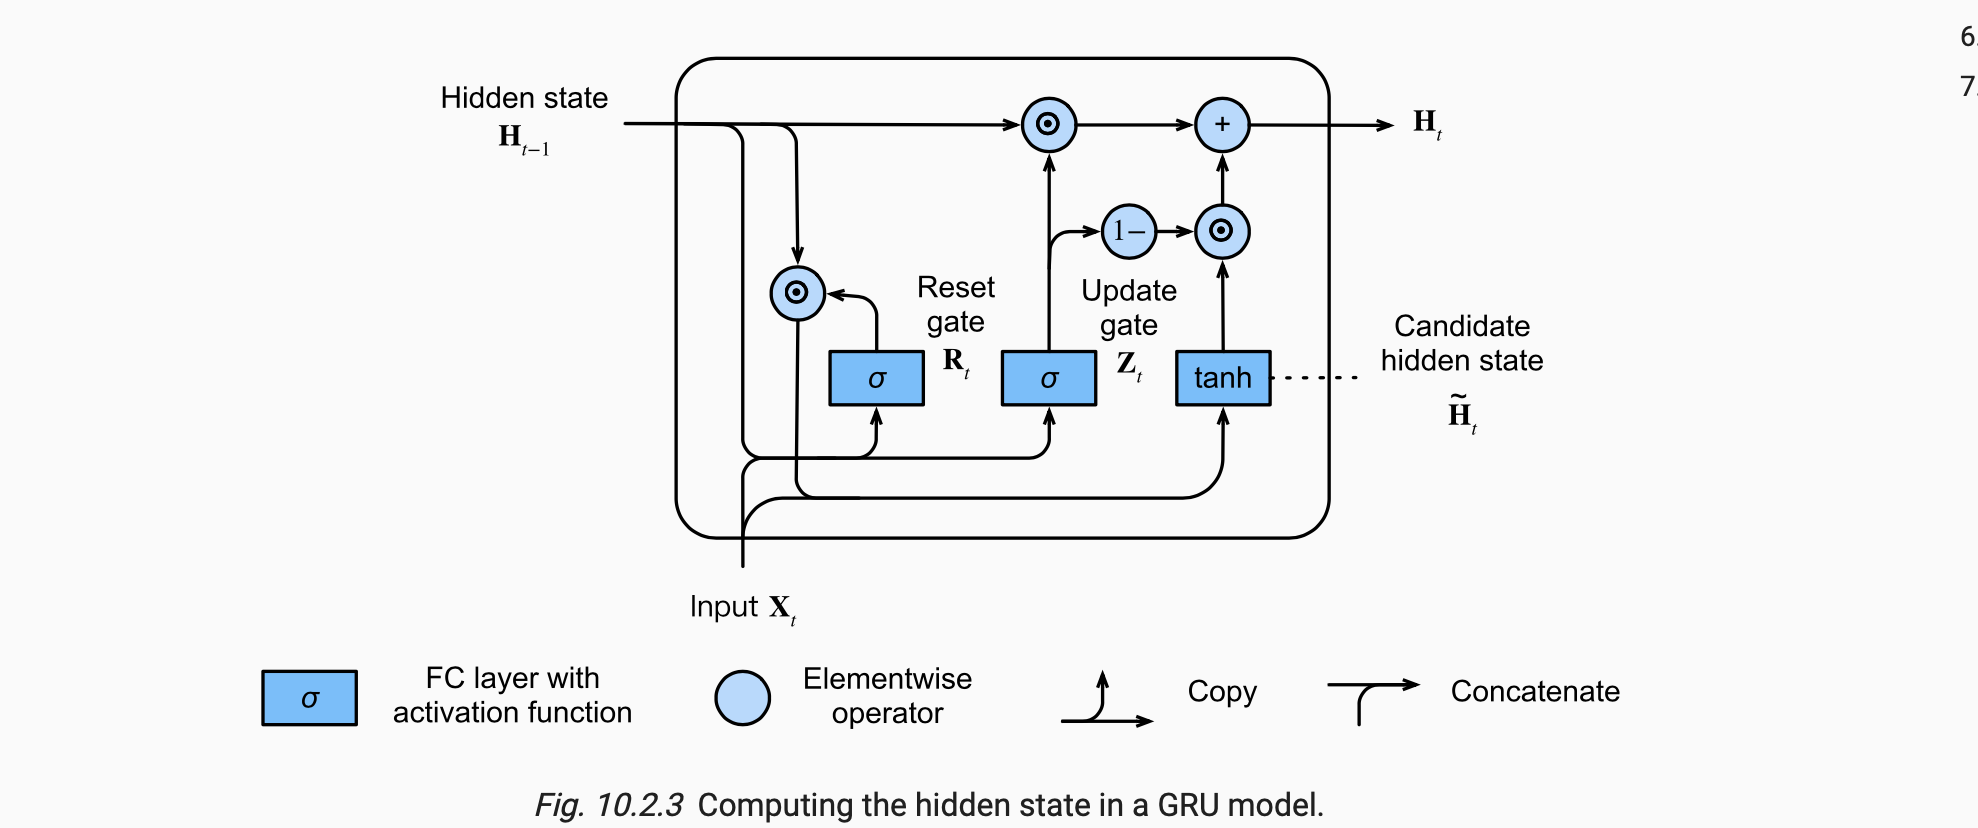
$$\begin{split}\begin{aligned}
\mathbf{R}_t = \sigma(\mathbf{X}_t \mathbf{W}_{xr} + \mathbf{H}_{t-1} \mathbf{W}_{hr} + \mathbf{b}_r),\\
\mathbf{Z}_t = \sigma(\mathbf{X}_t \mathbf{W}_{xz} + \mathbf{H}_{t-1} \mathbf{W}_{hz} + \mathbf{b}_z),
\end{aligned}\end{split}$$
$$\tilde{\mathbf{H}}_t = \tanh(\mathbf{X}_t \mathbf{W}_{xh} + \left(\mathbf{R}_t \odot \mathbf{H}_{t-1}\right) \mathbf{W}_{hh} + \mathbf{b}_h),$$
$$\mathbf{H}_t = \mathbf{Z}_t \odot \mathbf{H}_{t-1}  + (1 - \mathbf{Z}_t) \odot \tilde{\mathbf{H}}_t.$$

In [ ]:
class GRUScratch(d2l.Module):
     def __init__(self, num_inputs, num_hiddens, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()

        init_weight = lambda *shape:nn.Parameter(torch.rand(*shape)*sigma)
        triple=lambda: (init_weight(num_inputs,num_hiddens),
                        init_weight(num_inputs,num_hiddens),
                        nn.Parameter(torch.zeros(num_hiddens))
        )
        self.W_xz, self.W_hz, self.b_z = triple()  # Update gate
        self.W_xr, self.W_hr, self.b_r = triple()  # Reset gate
        self.W_xh, self.W_hh, self.b_h = triple()  # Candidate hidden state

In [10]:
@d2l.add_to_class(GRUScratch)
def forward(self, inputs, H=None):
    if H is None:
        # Initial state with shape: (batch_size, num_hiddens)
        H=torch.zeros((inputs.shape[1],self.num_hiddens),device=inputs.device)
    outputs = []
    for X in inputs:
        Z=torch.sigmoid(torch.mm(X,self.W_xz)+torch.mm(H,self.W_hz)+self.b_z)
        R=torch.sigmoid(torch.mm(X,self.W_xr)+torch.mm(H,self.W_hr)+self.b_r)
        H_tildle=torch.tanh(torch.mm(X,self.W_xh)+torch.mm(R*H,self.W_hh)+self.b_h)
        H=Z*H+(1-Z)*H_tildle
        outputs.append(H)
    return outputs,H

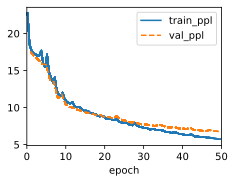

In [11]:
data = d2l.TimeMachine(batch_size=1024, num_steps=32)
gru = GRUScratch(num_inputs=len(data.vocab), num_hiddens=32)
model = d2l.RNNLMScratch(gru, vocab_size=len(data.vocab), lr=4)
trainer = d2l.Trainer(max_epochs=50, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

# Concise Implementation


In [12]:
class GRU(d2l.RNN):
    def __init__(self,num_inputs,num_hiddens):
        d2l.Module.__init__(self)
        self.save_hyperparameters()
        self.rnn=nn.GRU(num_inputs,num_hiddens)

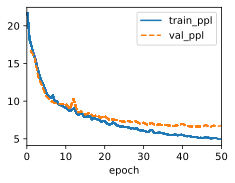

In [13]:
gru = GRU(num_inputs=len(data.vocab), num_hiddens=32)
model = d2l.RNNLM(gru, vocab_size=len(data.vocab), lr=4)
trainer.fit(model, data)

In [14]:
model.predict('it has', 20, data.vocab, d2l.try_gpu())

'it has existence the the t'